<a href="https://colab.research.google.com/github/tassid/img-processing/blob/main/utfpr_img_processing.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

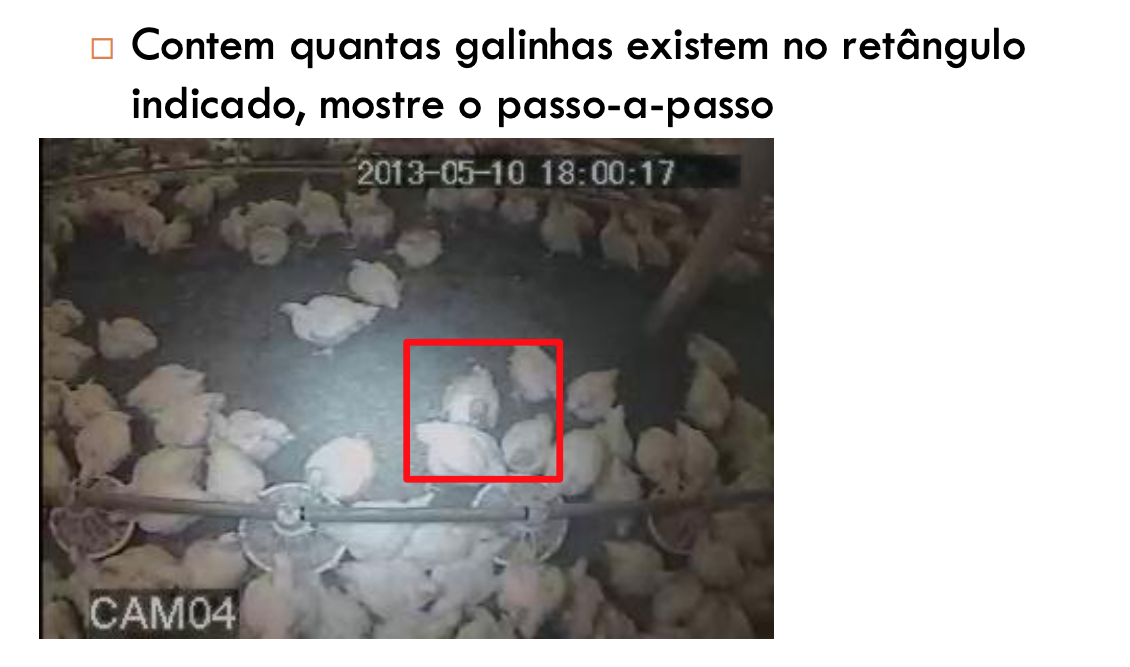

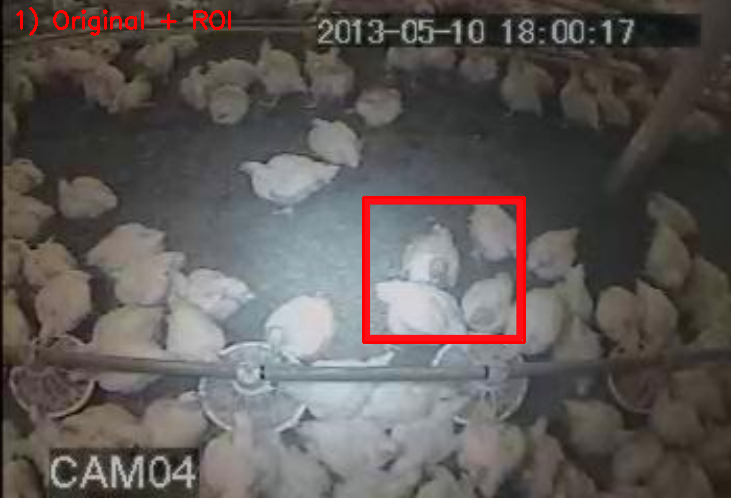

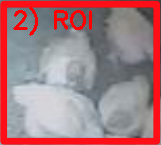

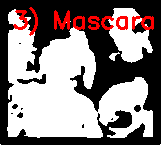

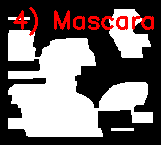

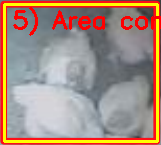

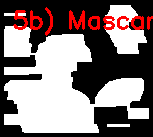

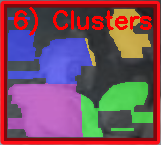

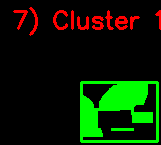

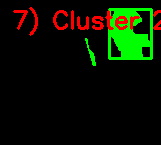

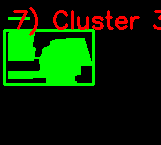

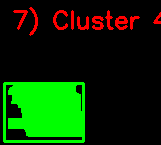

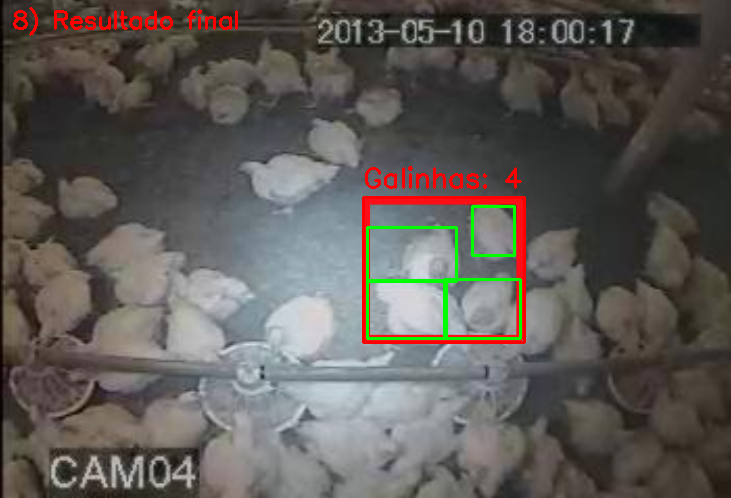

ROI: (363, 197, 161, 145)
Boxes: [(4, 30, 89, 54), (4, 83, 79, 58), (81, 82, 76, 59), (109, 9, 42, 49)]
Contagem: 4


In [ ]:
import cv2, numpy as np
from google.colab.patches import cv2_imshow

# ---------------- utilidades ----------------

def find_red_roi_box(img_bgr):
    hsv = cv2.cvtColor(img_bgr, cv2.COLOR_BGR2HSV)
    red = cv2.inRange(hsv, (0,80,70), (10,255,255)) | cv2.inRange(hsv, (170,80,70), (180,255,255))
    red = cv2.morphologyEx(red, cv2.MORPH_CLOSE, np.ones((5,5),np.uint8), 2)
    cnts,_ = cv2.findContours(red, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    if not cnts:
        return None
    H, W = img_bgr.shape[:2]
    best, best_area = None, 0
    for c in cnts:
        x,y,w,h = cv2.boundingRect(c)
        area = w*h
        if (W*H)*0.01 < area < (W*H)*0.5 and area > best_area:
            best, best_area = (x,y,w,h), area
    return best

def iou(a,b):
    ax,ay,aw,ah = a; bx,by,bw,bh = b
    ax2, ay2, bx2, by2 = ax+aw, ay+ah, bx+bw, by+bh
    ix1, iy1 = max(ax,bx), max(ay,by)
    ix2, iy2 = min(ax2,bx2), min(ay2,by2)
    inter = max(0, ix2-ix1) * max(0, iy2-iy1)
    union = aw*ah + bw*bh - inter + 1e-5
    return inter/union

def nms_keep_k(boxes, k=4, iou_thresh=0.4):
    boxes = sorted(boxes, key=lambda B: B[2]*B[3], reverse=True)
    kept = []
    for b in boxes:
        if all(iou(b, kb) < iou_thresh for kb in kept):
            kept.append(b)
        if len(kept) == k:
            break
    return kept

def put_title(img, text):
    out = img.copy()
    cv2.putText(out, text, (12, 28), cv2.FONT_HERSHEY_SIMPLEX, 0.8, (0,0,255), 2)
    return out

# ---------------- contador + passo a passo ----------------

def count_chickens_kmeans_with_steps(image, roi_rect, K=4, margin=4, show_steps=True):
    x,y,w,h = roi_rect
    roi = image[y:y+h, x:x+w].copy()

    # Step 1: original + ROI
    if show_steps:
        vis = image.copy()
        cv2.rectangle(vis, (x,y), (x+w,y+h), (0,0,255), 2)
        cv2_imshow(put_title(vis, "1) Original + ROI"))

    # Step 2: ROI crua
    if show_steps:
        cv2_imshow(put_title(roi, "2) ROI"))

    # Step 3: máscara por Otsu
    gray  = cv2.cvtColor(roi, cv2.COLOR_BGR2GRAY)
    clahe = cv2.createCLAHE(2.0,(8,8)).apply(gray)
    blur  = cv2.GaussianBlur(clahe,(5,5),0)
    _, th = cv2.threshold(blur, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)
    if show_steps:
        cv2_imshow(put_title(cv2.cvtColor(th, cv2.COLOR_GRAY2BGR), "3) Mascara Otsu"))

    # Step 4: limpeza (abre cano + fecha buracos)
    rod_kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (21,3))
    th_clean = cv2.morphologyEx(th, cv2.MORPH_OPEN,  rod_kernel, 1)
    th_clean = cv2.morphologyEx(th_clean, cv2.MORPH_CLOSE, np.ones((5,5),np.uint8), 1)
    if show_steps:
        cv2_imshow(put_title(cv2.cvtColor(th_clean, cv2.COLOR_GRAY2BGR), "4) Mascara limpa"))

    # Step 5: recorte com margem
    mc = th_clean[margin:h-margin, margin:w-margin]
    roi_margin_vis = roi.copy()
    cv2.rectangle(roi_margin_vis, (margin,margin), (w-margin, h-margin), (0,255,255), 2)
    if show_steps:
        cv2_imshow(put_title(roi_margin_vis, f"5) Area considerada (margin={margin})"))
        cv2_imshow(put_title(cv2.cvtColor(mc, cv2.COLOR_GRAY2BGR), "5b) Mascara dentro da margem"))

    ys, xs = np.where(mc > 0)
    if len(xs) < 20:
        return []

    # Step 6: K-means nos pixels (x,y)
    Z = np.float32(np.column_stack([xs, ys]))
    criteria = (cv2.TERM_CRITERIA_EPS + cv2.TERM_CRITERIA_MAX_ITER, 50, 0.5)
    _, labels, centers = cv2.kmeans(Z, K, None, criteria, 5, cv2.KMEANS_PP_CENTERS)

    # Visualizacao dos clusters
    if show_steps:
        color_map = [(0,255,0),(0,200,255),(255,0,0),(180,0,180),(0,120,255)]
        cluster_color = np.zeros((mc.shape[0], mc.shape[1], 3), dtype=np.uint8)
        for k in range(K):
            pts = Z[labels.ravel()==k].astype(np.int32)
            if pts.size:
                cluster_color[pts[:,1], pts[:,0]] = color_map[k % len(color_map)]
        overlay = roi.copy()
        overlay[margin:h-margin, margin:w-margin] = cv2.addWeighted(
            overlay[margin:h-margin, margin:w-margin], 0.5,
            cluster_color, 0.5, 0
        )
        cv2_imshow(put_title(overlay, "6) Clusters (K-means)"))

    # Step 7: caixa por cluster
    boxes = []
    min_pts = max(20, int(0.001 * (w*h)))
    for k in range(K):
        pts = Z[labels.ravel() == k]
        if pts.shape[0] < min_pts:
            continue
        cl_mask = np.zeros_like(mc, dtype=np.uint8)
        ptsi = pts.astype(np.int32)
        cl_mask[ptsi[:,1], ptsi[:,0]] = 255
        cl_mask = cv2.morphologyEx(cl_mask, cv2.MORPH_CLOSE, np.ones((9,9),np.uint8), 2)
        cnts,_ = cv2.findContours(cl_mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
        if not cnts:
            continue
        bx, by, bw, bh = cv2.boundingRect(max(cnts, key=cv2.contourArea))
        boxes.append((bx+margin, by+margin, bw, bh))

        if show_steps:
            cl_vis = np.zeros((mc.shape[0], mc.shape[1], 3), dtype=np.uint8)
            cl_vis[ptsi[:,1], ptsi[:,0]] = (0,255,0)
            cl_vis = cv2.cvtColor(cl_vis, cv2.COLOR_BGR2RGB)  # só para destacar
            cl_bgr = np.zeros_like(roi)
            cl_bgr[margin:h-margin, margin:w-margin] = np.dstack([cl_vis[:,:,2],cl_vis[:,:,1],cl_vis[:,:,0]])
            cv2.rectangle(cl_bgr, (bx+margin, by+margin), (bx+margin+bw, by+margin+bh), (0,255,0), 2)
            cv2_imshow(put_title(cl_bgr, f"7) Cluster {k+1} + caixa"))

    # Step 8: NMS + top-K e desenho final
    boxes = nms_keep_k(boxes, k=K, iou_thresh=0.4)
    out = image.copy()
    cv2.rectangle(out, (x,y), (x+w, y+h), (0,0,255), 2)
    for (bx,by,bw,bh) in boxes:
        cv2.rectangle(out, (x+bx, y+by), (x+bx+bw, y+by+bh), (0,255,0), 2)
    cv2.putText(out, f'Galinhas: {len(boxes)}', (x, max(y-10, 20)), cv2.FONT_HERSHEY_SIMPLEX, 0.9, (0,0,255), 2)
    if show_steps:
        cv2_imshow(put_title(out, "8) Resultado final"))

    return boxes

# ---------------- uso ----------------

image_path = '/content/chicken-test.jpg'   # troque se necessário
img = cv2.imread(image_path)
if img is None:
    raise FileNotFoundError('Imagem não encontrada. Ajuste image_path.')

roi_rect = find_red_roi_box(img)
if roi_rect is None:
    roi_rect = (420, 260, 160, 160)

boxes = count_chickens_kmeans_with_steps(img, roi_rect, K=4, margin=4, show_steps=True)

# também imprime no console
print("ROI:", roi_rect)
print("Boxes:", boxes)
print("Contagem:", len(boxes))


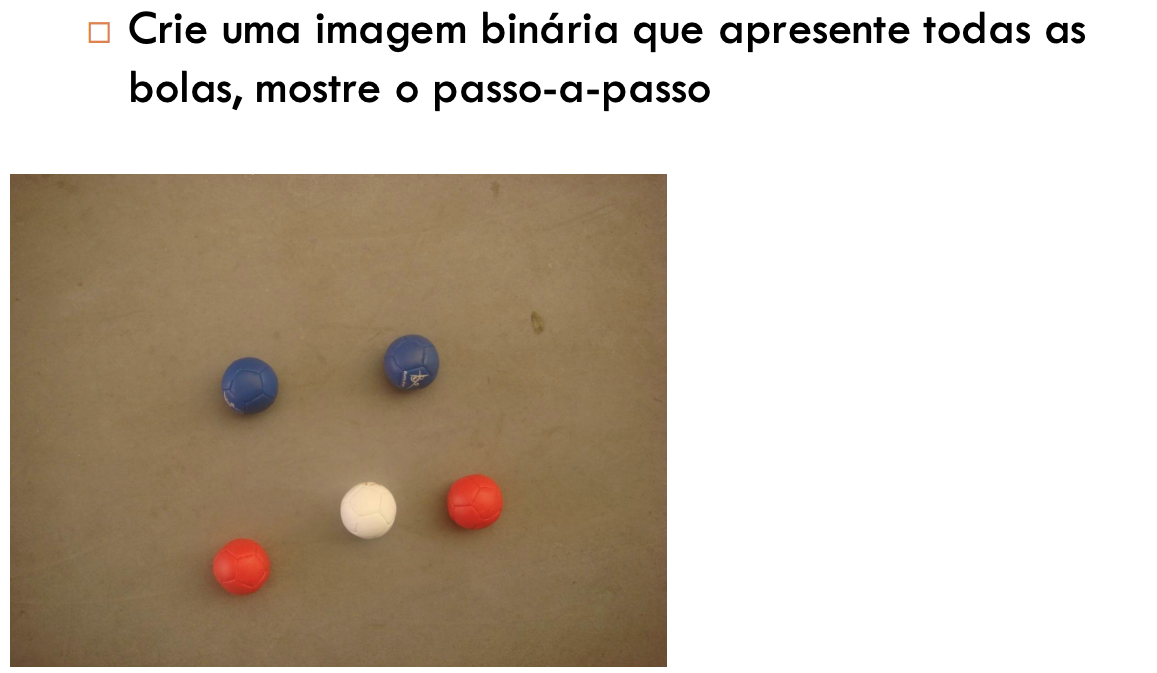

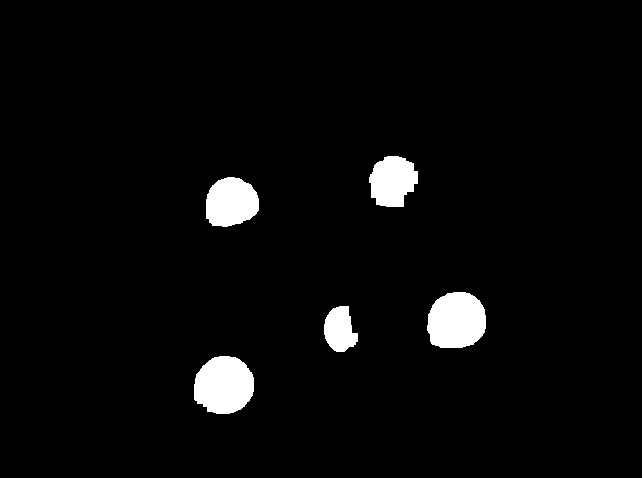

Salvo em: /content/balls_binary.png


In [ ]:
import cv2
import numpy as np
import os

image_path = '/content/bolas.png'

def balls_binary(image_path, save_path=None, show=False):
    img = cv2.imread(image_path)
    if img is None:
        raise FileNotFoundError(f"Não abriu: {image_path}")

    # 1) Recorte automático da foto (remove margens brancas do slide)
    hsv = cv2.cvtColor(img, cv2.COLOR_BGR2HSV)
    white = cv2.inRange(hsv, (0,0,220), (180,50,255))
    non_white = cv2.bitwise_not(white)
    non_white = cv2.morphologyEx(non_white, cv2.MORPH_OPEN,  np.ones((9,9),np.uint8), 1)
    non_white = cv2.morphologyEx(non_white, cv2.MORPH_CLOSE, np.ones((25,25),np.uint8), 1)
    cnts,_ = cv2.findContours(non_white, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    x,y,w,h = cv2.boundingRect(max(cnts, key=cv2.contourArea))
    photo = img[y:y+h, x:x+w]

    # 2) Segmentação HSV (azul, vermelho e branco)
    hsvp = cv2.cvtColor(photo, cv2.COLOR_BGR2HSV)
    mask_blue  = cv2.inRange(hsvp, (90, 70, 50), (125,255,255))
    mask_red   = cv2.inRange(hsvp, (0, 80, 60), (10,255,255)) | cv2.inRange(hsvp, (170,80,60), (179,255,255))
    mask_white = cv2.inRange(hsvp, (0,  0,150), (180, 65,255))
    mask = mask_blue | mask_red | mask_white

    # 3) Limpeza morfológica
    mask = cv2.morphologyEx(mask, cv2.MORPH_CLOSE, np.ones((23,23), np.uint8), 1)
    mask = cv2.morphologyEx(mask, cv2.MORPH_OPEN,  np.ones((5,5),  np.uint8), 1)

    # 4) Mantém apenas blobs com tamanho plausível e que não tocam a borda
    H, W = mask.shape
    num, labels, stats, _ = cv2.connectedComponentsWithStats(mask, 8)
    clean = np.zeros_like(mask)
    for i in range(1, num):
        x0,y0,w0,h0, area = stats[i,0], stats[i,1], stats[i,2], stats[i,3], stats[i, cv2.CC_STAT_AREA]
        touches = (x0<=1 or y0<=1 or x0+w0>=W-1 or y0+h0>=H-1)
        if 400 < area < H*W*0.2 and not touches:
            clean[labels == i] = 255

    binary = cv2.morphologyEx(clean, cv2.MORPH_CLOSE, np.ones((9,9), np.uint8), 1)

    # 5) Salvar
    if save_path is None:
        base = os.path.splitext(os.path.basename(image_path))[0]
        save_path = f"{base}_binary.png"
    cv2.imwrite(save_path, binary)

    if show:
        from google.colab.patches import cv2_imshow
        cv2_imshow(binary)

    return binary, save_path


binary, out_path = balls_binary('/content/bolas.png', '/content/balls_binary.png', show=True)
print('Salvo em:', out_path)